In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict

class Portfolio():
    def __init__(self,syms,sym_data):
        self.syms = syms
        self.sym_data = sym_data

class QTrader(object):
    def __init__(self, sym_data, eta=1, transaction_cost=0.005, position=10):
        self.sym_data = sym_data
        self.stock_data = sym_data#pd.merge(pd.read_csv('./tbill.csv', index_col='Date'), pd.read_csv('./^GSPC.csv', index_col='Date'), right_index=True, left_index=True).sort_index()
        ret = self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1)
        # These are price returns and the weekly returns for TBills (3 months)self.stock_data['Close']
        self.returns = pd.DataFrame({
                                        'stocks': self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1),
                                        'tbills': (ret.std()) ,
                                    }, index=self.stock_data.index)

        self.returns['risk_adjusted'] = (self.returns.stocks - self.returns.tbills)
        self.returns['risk_adjusted_moving'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.mean())
        self.returns['risk_adjusted_stdev'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.std())
        self.returns['risk_adjusted_high'] = self.returns.risk_adjusted_moving + 1.5 * self.returns.risk_adjusted_stdev
        self.returns['risk_adjusted_low'] = self.returns.risk_adjusted_moving - 1.5 * self.returns.risk_adjusted_stdev
        self.returns['state'] = (self.returns.risk_adjusted > self.returns.risk_adjusted_high).astype('int') - \
                                (self.returns.risk_adjusted < self.returns.risk_adjusted_high).astype('int') # pd.qcut(self.returns.sharpe_moving, 10, labels=range(10))
    def graph_portfolios(self):

        midpoint = int(len(self.returns.index) / 2)
        training_indexes = self.returns.index[:midpoint] 
        testing_indexes = self.returns.index[midpoint:]

        portfolios = pd.DataFrame({
            'buy_and_hold': self.buy_and_hold(testing_indexes),
            'buy_tbills': self.buy_tbills(testing_indexes),
            'random': self.random(testing_indexes),
            'qtrader': self.q_holdings(training_indexes, testing_indexes)
            }, index=testing_indexes)

        portfolio_values = pd.DataFrame({
                'buy_and_hold': self.evaluate(portfolios.buy_and_hold),
                'buy_tbills': self.evaluate(portfolios.buy_tbills),
                'random': self.evaluate(portfolios.random),
                'qtrader': self.evaluate(portfolios.qtrader)
            }, index=testing_indexes)
        
        portfolio_values.plot()

        plt.annotate("Buy and hold sharpe: {}\n QTrader sharpe: {}".format(self.sharpe(portfolios.buy_and_hold), self.sharpe(portfolios.qtrader)), xy=(0.25, 0.95), xycoords='axes fraction')
        
        plt.show()
        
    def buy_and_hold(self, dates):
        return pd.Series(1, index=dates)

    def buy_tbills(self, dates):
        return pd.Series(0, index=dates)

    # This will go long or short or do nothing randomly
    def random(self, dates):
        return pd.Series(np.random.randint(-1, 2, size=len(dates)), index=dates)

    def calc_returns(self, holdings):
        return pd.Series(self.returns.tbills + holdings * self.returns.risk_adjusted, index=holdings.index)

    def evaluate(self, holdings):
        return (self.calc_returns(holdings) + 1).cumprod()

    def state(self, first_moment, second_moment):
        return first_moment + second_moment * 10

    def q_holdings(self, training_indexes, testing_indexes):
        factors = pd.DataFrame({'action': 0, 'reward': 0, 'state': 0}, index=training_indexes)

        # Initialize Q matrix
        q = {0: {1:0, 0:0, -1:0}}
        
        # For Dyna-Q
        T = np.zeros((3, 3, 3)) + 0.00001
        R = np.zeros((3,3))

        # Episodes
        for i in range(100):
            last_row, last_date = None, None

            for date, row in factors.iterrows():
                return_data = self.returns.loc[date]
                if return_data.state not in q:
                    q[return_data.state] = {1: 0, 0:0, -1:0}

                if last_row is None or np.isnan(return_data.state):
                    state = 0
                    reward = 0
                    action = 0
                else:
                    state = int(return_data.state)
                    if random.random() > 0.001:
                        action = max(q[state], key=q[state].get)
                    else:
                        action = random.randint(-1,1)

                    reward = last_row.action * (return_data.stocks - return_data.tbills)

                    alpha = 1
                    discount = 0.9

                    factors.loc[date, 'reward'] = reward
                    factors.loc[date, 'action'] = action
                    factors.loc[date, 'state'] = return_data.state

                    update = alpha * (factors.loc[date, 'reward'] + discount * max(q[row.state].values()) - q[state][action])
                    if not np.isnan(update):
                        q[state][action] += update

                    # Dyna
                    action_idx = int(last_row.action+1)
                    state_idx = int(last_row.state+1)
                    new_state_idx = int(state+1)

                    T[state_idx][action_idx][new_state_idx] += 1
                    R[state_idx][action_idx] = (1 - alpha) * R[state_idx][action_idx] + alpha * reward

                last_date, last_row = date, factors.loc[date]

            for j in range(100):
                state_idx = random.randint(0,2)
                action_idx = random.randint(0,2)
                new_state = np.random.choice([-1, 0, 1], 1, p=T[state_idx][action_idx]/T[state_idx][action_idx].sum())[0]
                r = R[state_idx][action_idx]
                q[state][action] += alpha * (r + discount * max(q[new_state].values()) - q[state][action])

            sharpe = self.sharpe(factors.action)

            if sharpe > 0.20:
                break
            #print("For episode {} we get an internal sharpe ratio of {}".format(i, self.sharpe(factors.action)))

        testing = pd.DataFrame({'action': 0, 'state': 0}, index=testing_indexes)
        testing['state'] = self.returns.loc[testing_indexes, 'state']
        testing['action'] = testing['state'].apply(lambda state: max(q[state], key=q[state].get))

        print(self.sharpe(testing.action))

        return testing.action

    def discretize(self, number, steps):
        return 0

    def sharpe(self, holdings):
        returns = holdings * (self.returns.stocks - self.returns.tbills)

        return np.nanmean(returns) / np.nanstd(returns)

    


In [2]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = '/githome/me/Documents/BWA/data/bw_portfolios'

#Open binance client
client = Client(api_key, secret_key)

#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))


def get_data(sym,prev_k,k,candle_k='5m'):
    """
    Function downloads hist data from binance API with given timestamps
    """
    #previous kline interval
    prev_k = str(prev_k)
    #current kline interval
    k = str(k)
    #download historical data
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def to_dt(v,is_milli=True):
    """
    Function to convert timestamp to datetime object
    has parameter for millisecond uts timestamp
    """
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    """
    Function loads all signal csv files and concatenates them into a signle dataframe
    """
    # cd cmd
    os.chdir(bw_location)
    #sorting by file creation (could use normal sort as filenames are timestamps)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    #Create frequency signal dataframe
    fs_df = pd.DataFrame(files)
    #sort again
    fs_df = fs_df[0].sort_values()
    #starttime,endtime
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    """
    Function to clean frequency signal dataframe
    """
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    """
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
    """    
    return fs



def unix_time_millis(dt):
    """
    Function to convert unix time to millesecond
    """
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    """
    Function to resample frequency dataframe to specified frequency
    
    """
    intv_list = []
    out = pd.DataFrame()
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        intv_list.append(p)
        data = fs_c.loc[p:n]
        #print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        
    return out.sort_index(),intv_list
    #files.sort(key=lambda x: os.path.getmtime(x))


/home/me/catalyst-venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Generate portfolios

In [3]:

def intv_port(freq_df,intv):
    dates = freq_df.index.get_level_values('Date').drop_duplicates()
    coins = freq_df.index.get_level_values('Coin')
    date_int = pd.DataFrame({"Date":[d.strftime('%Y-%m-%d') for d in dates]})
    date_int = date_int.drop_duplicates()
    date_int = date_int.astype('datetime64[s]')
    intv_dates = list(date_int.Date[::intv])
    port = pd.DataFrame()
    for c,day in enumerate(intv_dates):
        try:
            st,end = day,intv_dates[c+1]
            print(st,end)
            curr = freq_df.loc[st:end].reset_index()
            curr['Date'] = end

        except Exception as e:
            #print(e)
            break

        curr['all_freq'] = curr.groupby('Coin')['Coin'].transform('count')
        curr = curr[['Date','Coin','Close','all_freq']].sort_values("all_freq",ascending=False)
        curr = curr.sort_values(['Date'],ascending=False)
        curr = curr.set_index('Date')
        port_coins = curr.Coin.drop_duplicates()
        c_group = curr.groupby('Coin')
        curr_port = pd.DataFrame()
        for pc in port_coins:
            curr = c_group.get_group(pc).head(1)
            curr_port = pd.concat([curr_port,curr])
            curr_port = curr_port.sort_values("all_freq",ascending=False).head(9)
        port = pd.concat([port,curr_port])
    
    port = port.reset_index()
    #print(port)
    port['Date'] = port['Date'].astype('datetime64[ns]')
    #print(port)
    #print(port['Date'])
    d2 = [d.strftime('%Y-%m-%d') for d in port.Date]
    port['Date'] = d2
    #
    return port

#get freq. signal df
freq_loc = '/home/me/Documents/BWA/data/freq_concat.csv'
fs = pd.read_csv(freq_loc)
#clean freq. signal df
fs_c = clean_fs(fs)
#multilevel indexing for interval tracking
fs_c = fs_c.set_index(['Date','Coin'])
str_intv = input("portfolio interval: ")
intv = int(str_intv)
port = intv_port(fs_c,intv)
#print(port)
port = port.sort_values(['Date','all_freq'],ascending=[True,False])
port = port.set_index(['Date','Coin'])
port.to_csv("/home/me/Documents/BWA/data/{}day_portfolio.csv".format(intv))


portfolio interval: 7
2018-08-24 00:00:00 2018-09-04 00:00:00
2018-09-04 00:00:00 2018-09-11 00:00:00
2018-09-11 00:00:00 2018-09-18 00:00:00
2018-09-18 00:00:00 2018-09-25 00:00:00
2018-09-25 00:00:00 2018-10-02 00:00:00
2018-10-02 00:00:00 2018-10-09 00:00:00
2018-10-09 00:00:00 2018-10-16 00:00:00
2018-10-16 00:00:00 2018-10-23 00:00:00
2018-10-23 00:00:00 2018-10-30 00:00:00
2018-10-30 00:00:00 2018-11-06 00:00:00
2018-11-06 00:00:00 2018-11-13 00:00:00
2018-11-13 00:00:00 2018-11-23 00:00:00
2018-11-23 00:00:00 2018-11-30 00:00:00
2018-11-30 00:00:00 2018-12-07 00:00:00
2018-12-07 00:00:00 2018-12-14 00:00:00
2018-12-14 00:00:00 2018-12-21 00:00:00
2018-12-21 00:00:00 2018-12-28 00:00:00
2018-12-28 00:00:00 2019-01-04 00:00:00
2019-01-04 00:00:00 2019-01-11 00:00:00
2019-01-11 00:00:00 2019-01-18 00:00:00
2019-01-18 00:00:00 2019-01-25 00:00:00
2019-01-25 00:00:00 2019-02-01 00:00:00


In [4]:
port.iloc[-9:]

Close  all_freq
Date       Coin                       
2019-02-01 ENGBTC   0.000076       148
           CVCBTC   0.000014       147
           MDABTC   0.000215       146
           APPCBTC  0.000013       145
           GXSBTC   0.000155       140
           SUBBTC   0.000012       123
           REPBTC   0.003401       116
           KMDBTC   0.000181       115
           POWRBTC  0.000024        97

# Analyze portfolio

Portfolio lookback window2
Index(['2019-01-25', '2019-02-01'], dtype='object', name='Date')
2019-01-25 00:00:00 2019-02-01 00:00:00
Fitting the rolling Linear Regression...
                         feature1
Open time                        
2019-01-25 01:35:00 -1.080041e-08
2019-01-25 01:40:00 -8.123689e-09
2019-01-25 01:45:00 -5.989509e-09
2019-01-25 01:50:00 -3.042850e-09
2019-01-25 01:55:00 -5.320310e-10
1998 1998
                      APPCBTC  BTCUSDT   hedge_ratio
Open time                                           
2019-01-25 01:35:00  0.000013  3576.08 -1.080041e-08
2019-01-25 01:40:00  0.000013  3575.75 -8.123689e-09
2019-01-25 01:45:00  0.000013  3575.69 -5.989509e-09
2019-01-25 01:50:00  0.000013  3578.39 -3.042850e-09
2019-01-25 01:55:00  0.000013  3578.39 -5.320310e-10
Creating the spread/zscore columns...
z avg:  1.0044239936498663e-15
z std:  1.0002503442272284
z max:  5.42777353456852
z min:  -3.8393980511708676
                      APPCBTC  BTCUSDT   hedge_ratio    spr

/home/me/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Constructing a portfolio...
Constructing the equity curve...


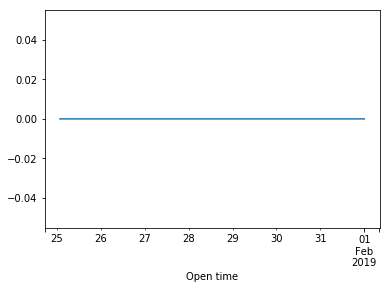

  File "<ipython-input-18-a9b64d5d3786>", line 181, in <module>
    curr_port_hist.cumsum().plot()
Empty 'DataFrame': no numeric data to plot
2019-02-01 00:00:00 2019-02-01 00:00:00
Fitting the rolling Linear Regression...
  File "<ipython-input-18-a9b64d5d3786>", line 47, in <module>
    rolling = ols.PandasRollingOLS(y=pairs[symbols[0]], x=pairs[symbols[1]], window=20)
data already contains a constant


""


In [18]:
import ffn
from pyfinance import ols
import traceback, sys
#loop test thresholds
z_entry_threshold=1.
z_exit_threshold=-.8
    
p_dates = port.index.get_level_values('Date').drop_duplicates()
n_day = int(input("Portfolio lookback window"))
last_n = p_dates[-n_day:]
print(last_n)
returns = []
all_ports = pd.DataFrame()
for c,d in enumerate(last_n):

    if(c>len(last_n)-1):
        break
    try:
        st = datetime.datetime.strptime(d, '%Y-%m-%d')
        if(len(last_n)==2):
            end = datetime.datetime.strptime(last_n[-1], '%Y-%m-%d')
        else:
            end = datetime.datetime.strptime(last_n[c+1], '%Y-%m-%d')
        print(st,end)
        
        st,end = int(unix_time_millis(st)),int(unix_time_millis(end))
        prev_st = st-86400000*intv
        curr_port = port.loc[d]
        p_coins = curr_port.index.get_level_values('Coin').values
        curr_port_hist = pd.DataFrame()
        for coin in p_coins:
            #current hist ...lazy way
            #q_hist = get_data(coin,prev_st,end,candle_k='1h')
            #q trader hist with prior data for training
            #coin hist
            c_hist = get_data(coin,st,end,candle_k='5m')
            #btc hist
            btc_hist = get_data('BTCUSDT',st,end,candle_k='5m')
            symbols = [coin,'BTCUSDT']
            #intraday pairs df
            pairs = pd.DataFrame(index=c_hist.index)
            pairs[symbols[0]] = c_hist['Close'].values
            pairs[symbols[1]] = btc_hist['Close'].values
            pairs = pairs.dropna()
            # linear regression between the two closing price time series
            print("Fitting the rolling Linear Regression...")
            rolling = ols.PandasRollingOLS(y=pairs[symbols[0]], x=pairs[symbols[1]], window=20)
            #model = sm.OLS(y=btc_hist['Close'].values, X=c_hist['Close'].values).fit()
            #model = sm.OLS(y=pairs['%s_close' % symbols[0].lower()], 
                           #X=pairs['%s_close' % symbols[1].lower()],
                           #).fit()
            
            
            
            # Construct the hedge ratio and eliminate the first 
            # lookback-length empty/NaN period
            #res.params
            beta = rolling.beta
            print(beta.head())
            pairs['hedge_ratio'] = beta
            pairs = pairs.dropna()
            print(len(beta),len(pairs))
            print(pairs.head())
            # Create the spread and then a z-score of the spread
            print("Creating the spread/zscore columns...")
            pairs['spread'] = pairs[symbols[0]] - pairs['hedge_ratio']*pairs[symbols[1]]
            pairs['zscore'] = (pairs['spread'] - np.mean(pairs['spread']))/np.std(pairs['spread'])
            
            print("z avg: ", pairs['zscore'].mean())
            print("z std: ", pairs['zscore'].std())
            print("z max: ", pairs['zscore'].max())
            print("z min: ", pairs['zscore'].min())
            """Create the entry/exit signals based on the exceeding of 
            z_enter_threshold for entering a position and falling below
            z_exit_threshold for exiting a position."""

            # Calculate when to be long, short and when to exit
            pairs['longs'] = (pairs['zscore'] <= -z_entry_threshold)*1.0
            pairs['shorts'] = (pairs['zscore'] >= z_entry_threshold)*1.0
            pairs['exits'] = (np.abs(pairs['zscore']) <= z_exit_threshold)*1.0

            # These signals are needed because we need to propagate a
            # position forward, i.e. we need to stay long if the zscore
            # threshold is less than z_entry_threshold by still greater
            # than z_exit_threshold, and vice versa for shorts.
            pairs['long_market'] = 0.0
            pairs['short_market'] = 0.0
            print(pairs.head())
            # These variables track whether to be long or short while
            # iterating through the bars
            long_market = 0
            short_market = 0

            # Calculates when to actually be "in" the market, i.e. to have a
            # long or short position, as well as when not to be.
            # Since this is using iterrows to loop over a dataframe, it will
            # be significantly less efficient than a vectorised operation,
            # i.e. slow!
            print("Calculating when to be in the market (long and short)...")
            for i, b in enumerate(pairs.iterrows()):
                # Calculate longs
                if b[1]['longs'] == 1.0:
                    long_market = 1            
                # Calculate shorts
                if b[1]['shorts'] == 1.0:
                    short_market = 1
                # Calculate exists
                if b[1]['exits'] == 1.0:
                    long_market = 0
                    short_market = 0
            # This directly assigns a 1 or 0 to the long_market/short_market
            # columns, such that the strategy knows when to actually stay in!
            pairs.ix[i]['long_market'] = long_market
            pairs.ix[i]['short_market'] = short_market
            

            # Construct the portfolio object with positions information
            # Note that minuses to keep track of shorts!
            print("Constructing a portfolio...")
            portfolio = pd.DataFrame(index=pairs.index)
            portfolio['positions'] = pairs['long_market'] - pairs['short_market']
            portfolio[symbols[0]] = -1.0 * pairs[symbols[0]] * portfolio['positions']
            portfolio[symbols[1]] = pairs[symbols[1]] * portfolio['positions']
            portfolio['total'] = portfolio[symbols[0]] + portfolio[symbols[1]]
            
            # Construct a percentage returns stream and eliminate all 
            # of the NaN and -inf/+inf cells
            print("Constructing the equity curve...")
            portfolio['returns'] = portfolio['total'].pct_change()
            portfolio['returns'].fillna(0.0, inplace=True)
            portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
            portfolio['returns'].replace(-1.0, 0.0, inplace=True)

            # Calculate the full equity curve
            portfolio['returns'] = (portfolio['returns'] + 1.0).cumprod()
            portfolio['total'].plot()
            #portfolio.returns.plot()
            plt.show()
    
    

            break
            
            
            #qb_hist = get_data('BTCUSDT',prev_st,end,candle_k='1h')
            """
            #this one works needs testing
            q_hist['Stdev'] = q_hist['Close'].rolling(window=12).std()
            q_hist['Moving Average'] = q_hist['Close'].rolling(window=24).mean()
            q_hist['Criteria1'] = (q_hist['Open'] - q_hist['Low'].shift(1)) < -q_hist['Stdev']
            q_hist['Criteria2'] = q_hist['Open'] > q_hist['Moving Average']
            q_hist['BUY'] = q_hist['Criteria1'] & q_hist['Criteria2']
            q_hist['Pct Change'] = (q_hist['Close'] - q_hist['Open']) / q_hist['Open']
            q_hist['Returns'] = q_hist['Pct Change'][q_hist['BUY'] == True]
            q_hist['Returns'].fillna(0).plot()
            
            curr_port_hist[coin] = q_hist['Returns'].values
            
            qt = QTrader(q_hist)
            print(qt.buy_and_hold(t_hist.index))
            #later replace with corr data
            midpoint = int(len(qt.returns.index) / 2)
            training_indexes = qt.returns.index[:midpoint] 
            testing_indexes = qt.returns.index[midpoint:]
            sym_trade = qt.q_holdings(training_indexes,testing_indexes)
            c_hist["btc returns"] = btc_hist['Close']#
            c_hist['sym_btc'] = c_hist["btc returns"]*c_hist['Close']
            c_hist['sym_btc'] = c_hist['sym_btc'].pct_change() 
            c_hist['Signal'] = sym_trade
            c_hist['cpct'] = c_hist['Close'].pct_change()
            c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
            c_hist['Strategy'] = c_hist['sym_btc'] * c_hist['Signal']#.shift(1)
            #print(c_hist[[]].head(10))
            c_hist[['sym_btc','Strategy']].cumsum().plot(grid=True,figsize=(8,5))
            #c_hist[['Close','Signal']].plot(subplots=True,grid=True)
            #plt.show()
            """
            
          
        #perf = ffn.calc_stats(curr_port_hist)
        curr_port_hist.cumsum().plot()
        plt.show()
        all_ports = pd.concat([all_ports,curr_port_hist],axis=0)
        #print(curr_port_hist.head()) 
        #print(p_coins)
        
    except Exception as e:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        traceback.print_tb(exc_traceback, limit=1, file=sys.stdout)
        print(e)
        
        pass
all_ports
#all_ports= all_ports.fillna(0)
#all_ports.to_csv(fname+"all_coins.csv")


In [23]:
all_ports

""


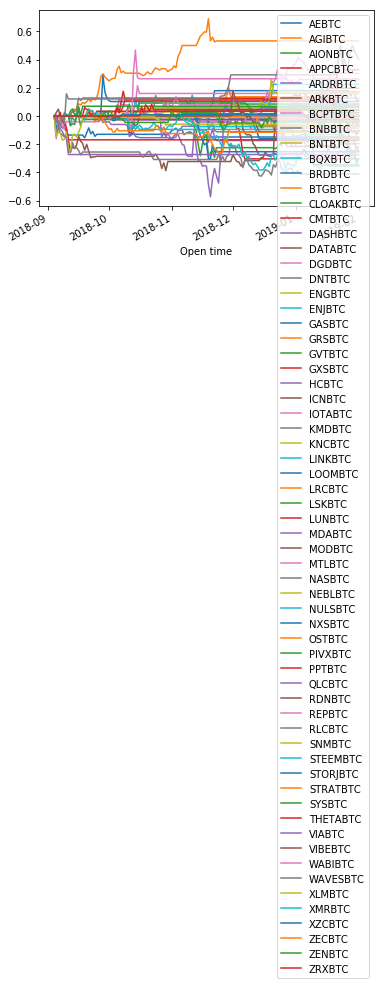

In [51]:
all_ports.fillna(0).cumsum().plot()